# Retirement Planner

---

## Environment Setup

In [20]:
! pip install alpaca-trade-api

# I have to re-install the alpaca-trade-api from the notebook for it to run in the notebook. If I don't do this it says that the alpaca
# trade API isn't installed even though it is installed in my base environment. I don't know why.

# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [21]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [22]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [23]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [9]:
# Display sample data
df.head()

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [24]:
# Calculate the daily roi for the individual stocks. (This entire section gets returns for the stocks individually, the 60/40 weight of the
# portfolio is considered when computing the returns of the entire portfolio.)

daily_returns = df.pct_change()

# Display sample data

daily_returns.head()

# Calculate average daily returns. I then check the results

avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
#avg_daily_return_agg
#avg_daily_return_spy



In [25]:
# Compute daily volatility. the #'d out code prints the results.

std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
#std_dev_daily_return_agg
#std_dev_daily_return_spy

In [26]:
# Save the last day's closing price. the #'d out code checks the value

agg_last_price = df['AGG']['close'][-1]
spy_last_price = df['SPY']['close'][-1]

#print(agg_last_price)
#print(spy_last_price)

In [27]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

In [34]:
# Run the Monte Carlo Simulation

# Initialize empty DataFrame to hold simulated prices for each simulation, and declare empty lists for the individual stock prices.
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()
simulated_agg_prices = []
simulated_spy_prices = []

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `JNJ` and `MU`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

simulated_daily_returns.head()

,SPY prices,AGG prices
0,NaN,NaN
1,-0.000340,-0.004004
2,-0.002158,0.000611
3,-0.004860,-0.002144
4,0.002523,0.003316


In [35]:
# Check that the simulation ran successfully - the projections for the individual stocks are printed above.
# Print records from the DataFrame

portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.006721,0.999442,0.998982,0.998631,1.007725,0.996021,1.003088,0.998853,1.002105,1.006692,...,1.002369,1.001967,0.998479,1.013219,0.995242,1.009911,1.002303,0.999704,1.001426,0.998195
2,1.006459,1.004598,0.992849,0.992657,1.012630,0.997227,1.002099,1.001710,0.993977,0.997324,...,0.998409,0.999102,1.003695,1.009557,0.995759,1.012837,1.010471,0.996325,1.000922,0.997147
3,1.006600,1.010785,0.991065,0.991706,1.007783,1.006118,0.994049,1.001247,0.993199,1.000707,...,0.995391,0.999044,1.005192,1.007860,0.997407,1.016499,1.017449,0.991667,1.001865,0.993384
4,1.004227,1.003911,0.989627,0.985967,1.006737,1.005515,0.991939,0.988753,0.987344,1.002651,...,0.989545,0.995995,1.002161,1.010235,1.002968,1.020809,1.012399,0.986989,0.998038,0.996205


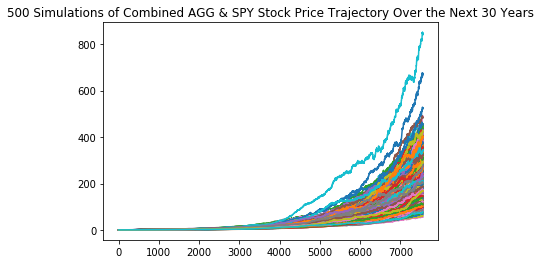

In [37]:
# Visualize the Simulation

plot_title = f"{n+1} Simulations of Combined AGG & SPY Stock Price Trajectory Over the Next 30 Years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)


In [48]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)

last_row_simulated_ending_portfolio_values = portfolio_cumulative_returns.iloc[-1]
print(last_row_simulated_ending_portfolio_values)

0      189.402829
1      169.181532
2      297.433580
3      110.864233
4      135.181295
          ...    
495    185.371498
496    174.217231
497    203.992083
498    170.585083
499     77.216985
Name: 7560, Length: 500, dtype: float64


In [42]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)


In [49]:
# Display the 90% confidence interval for the ending returns
confidence_interval = last_row_simulated_ending_portfolio_values.quantile(q=[0.05, 0.95])
print(confidence_interval)

0.05     94.422202
0.95    382.268623
Name: 7560, dtype: float64


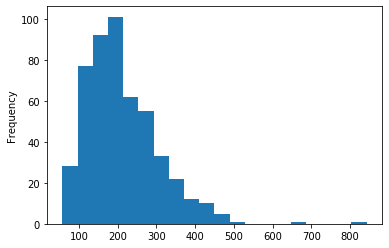

In [52]:
# Visualize the distribution of the ending returns. 

last_row_simulated_ending_portfolio_values.plot(kind='hist', bins=20)


---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [54]:
# Compute cumulative returns

tenth_percentive_confidence_interval = last_row_simulated_ending_portfolio_values.quantile(q=[0.45, 0.55])
fiftieth_percentive_confidence_interval = last_row_simulated_ending_portfolio_values.quantile(q=[.5,.5])
ninetieth_percentive_confidence_interval = last_row_simulated_ending_portfolio_values.quantile(q=[.05,.85])

print(f"The range for the 10th Percentile is {tenth_percentive_confidence_interval}, the range for the fiftieth percentile is {fiftieth_percentive_confidence_interval}, and the range for the nintieth is {ninetieth_percentive_confidence_interval}.")

pandas.core.series.Series

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [60]:
# Declare a function that will give the portfolio return

initial_investment = 0
portfolio_last_price = (agg_last_price + spy_last_price)
specific_confidence_interval = tenth_percentive_confidence_interval
specific_percentile = 0

def portfolio_return_calculator(initial_investment, specific_confidence_interval, specific_percentile):

# Declare variables for the function, initial investment the confidence interval you're looking for, and the associated percentile.
# I was unsure how to declare an empty series so used a known one.
# Calculate cumulative profit/loss of lower and upper bound
    cumulative_portfolio_lower_bound = initial_investment * ((specific_confidence_interval.iloc[0] - portfolio_last_price) / portfolio_last_price)
    cumulative_portfolio_upper_bound = initial_investment * ((specific_confidence_interval.iloc[1] - portfolio_last_price) / portfolio_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
    ending_investment_lower_bound = initial_investment + cumulative_portfolio_lower_bound
    ending_investment_upper_bound = initial_investment + cumulative_portfolio_upper_bound

# Print the results
    print(f"There is a {specific_percentile}% chance that an initial investment of $20,000 in a portfolio composed of 60% AGG Stock and 40% SPY Bonds"
          f" over the next 30 years of trading days will end within in the range of"
          f" ${ending_investment_lower_bound} and ${ending_investment_upper_bound}")
    
portfolio_return_calculator(20000, tenth_percentive_confidence_interval, 10) 
portfolio_return_calculator(20000, fiftieth_percentive_confidence_interval, 50) 
portfolio_return_calculator(20000, ninetieth_percentive_confidence_interval, 90) 


There is a 10% chance that an initial investment of $20,000 in a portfolio composed of 60% AGG Stock and 40% SPY Bonds over the next 30 years of trading days will end within in the range of $8504.202068210927 and $9437.6853346412
There is a 50% chance that an initial investment of $20,000 in a portfolio composed of 60% AGG Stock and 40% SPY Bonds over the next 30 years of trading days will end within in the range of $9135.742450487125 and $9135.742450487125
There is a 90% chance that an initial investment of $20,000 in a portfolio composed of 60% AGG Stock and 40% SPY Bonds over the next 30 years of trading days will end within in the range of $4348.6483892642445 and $13787.224752163693


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

# Set Plaid's projected income. I can't do this because I couldn't get the Plaid to work, so I've answered this by calculating 
# 4% of the 10th percentile return and comparing it to the initial investment. I asked Garance about this and he said to simply 
# take 4% of the expected return, which doesn't make sense so I can't answer the question.



### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [62]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
portfolio_return_calculator(30000, tenth_percentive_confidence_interval, 10) 

There is a 10% chance that an initial investment of $20,000 in a portfolio composed of 60% AGG Stock and 40% SPY Bonds over the next 30 years of trading days will end within in the range of $12756.30310231639 and $14156.528001961802


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# Compute projected returns

# Display sample data


In [ ]:
# Plot the cumulative returns over time


In [ ]:
# Compute portfolio performance over time

# Plot projected performance over time
